In [1]:
%load_ext autoreload
%autoreload 2
from labeling import dataload
import matplotlib.colors as pcl
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from CO2_identify import *
from mynetwork import CO2mask
from torch.utils.data import DataLoader
from scipy.ndimage import gaussian_filter
from torchvision.transforms.functional import resize


import torchvision
import torch
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import json
from torchstat import stat

# Display 2D U-net predictions

In [2]:
outpath = '../figures'

## get basic pathes

In [3]:
fn = '../define_path.txt'
with open(fn) as f:
    lines = f.readlines()
for idx, line in enumerate(lines):
    if idx == 1:
        dir_co2 = line.split('=')[1][:-1]
    if idx == 13:
        train_2DU = line.split('=')[1][:-1]
    if idx == 15:
        test2D = line.split('=')[1][:-1]

fn_tsmask = 'tsMask.dat'
path_bestnet = '../resources/NNpred2D/co2_identify_best.pt'

## plot training patches and print them

In [4]:
# sample training patch
train_id = [562,1009]

In [5]:
# load the network
networktest = CO2mask()
networktest.load_state_dict(torch.load(f'{path_bestnet}',map_location=torch.device('cpu')))
networktest = networktest.eval()

/tmp/ipykernel_1199066/2664842805.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  networktest.load_state_dict(torch.load(f'{path_bestnet}',map_location=torch.device('cpu

In [6]:
ptf = 'patch_info_train.csv'
# readin in patch information file
pf = pd.read_csv(f'{train_2DU}/{ptf}')
pid = pf['Ptch_id']
mid = pf['Mask_id']
R0 = []
Rt = []
mr = []
mp = []
for i in train_id:
    R0t = np.fromfile(f'{train_2DU}/R0t_{pid[i]}.dat',dtype=np.float32)
    R0t = np.reshape(R0t,(2,64,64))
    R0.append(R0t[0])
    Rt.append(R0t[1])
    Mr = np.fromfile(f'{train_2DU}/Mask_{mid[i]}.dat',dtype=np.float32)
    Mr = np.reshape(Mr,(64,64))
    mr.append(Mr)
    Mp = networktest(torch.tensor(R0t).unsqueeze(0)).detach().numpy()[0,0]
    mp.append(Mp)

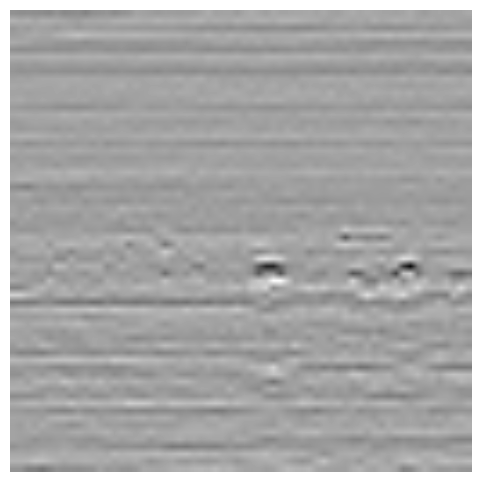

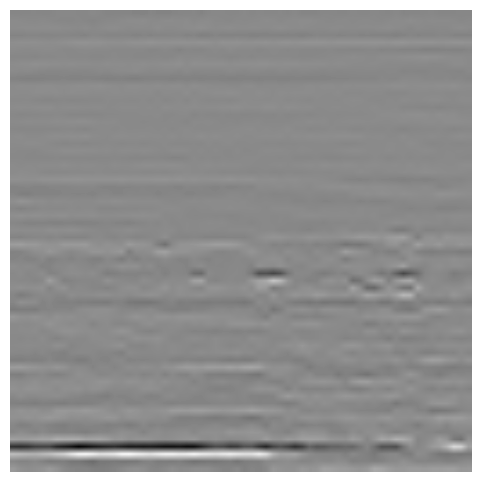

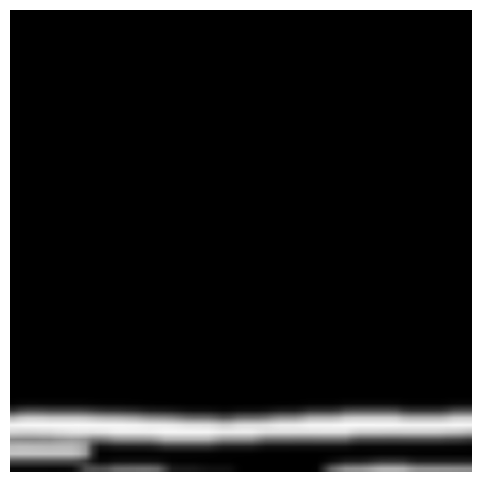

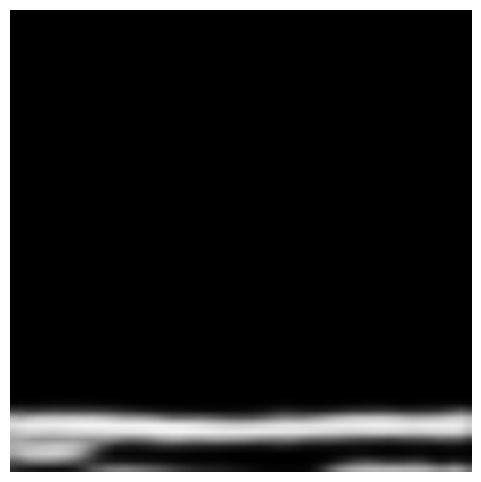

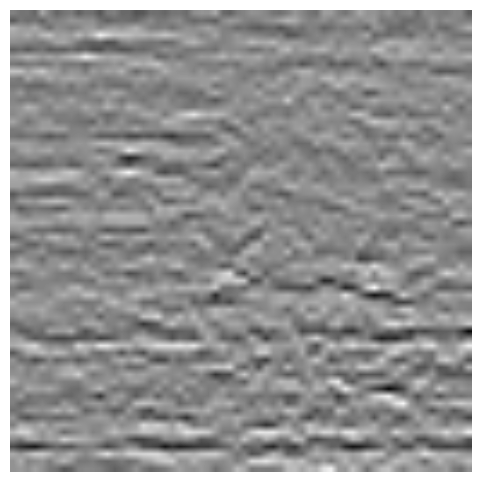

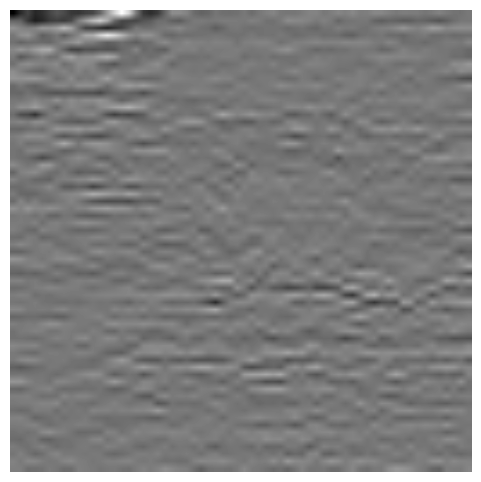

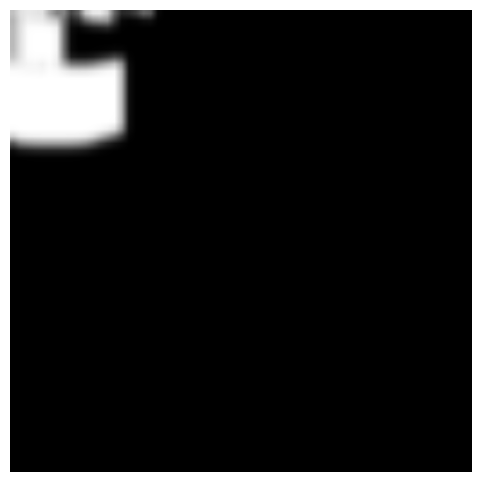

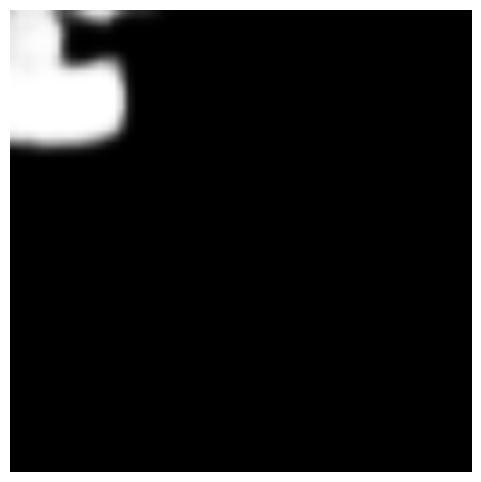

In [7]:
import os
# Ensure the output directory exists
os.makedirs(outpath, exist_ok=True)
# plot all 2D figures for the two training patches
for i in range(2):
    # plot R0
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    ax.imshow(R0[i].T,aspect=1,cmap='gray',interpolation='bilinear')
    ax.axis('off')
    fig.savefig(f'{outpath}/figD2-1_R0_{i}.png',dpi=300)
    # plot Rt
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    ax.imshow(Rt[i].T,aspect=1,cmap='gray',interpolation='bilinear')
    ax.axis('off')
    fig.savefig(f'{outpath}/figD2-1_Rt_{i}.png',dpi=300)
    # plot Mr
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    ax.imshow(mr[i].T,aspect=1,cmap='gray',interpolation='bilinear',vmin=0,vmax=1)
    ax.axis('off')
    fig.savefig(f'{outpath}/figD2-1_mr_{i}.png',dpi=300)
    # plot Mp
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    ax.imshow(mp[i].T,aspect=1,cmap='gray',interpolation='bilinear',vmin=0,vmax=1)
    ax.axis('off')
    fig.savefig(f'{outpath}/figD2-1_mp_{i}.png',dpi=300)
    

## plot test results

### define the 3D ploting function

In [8]:
# define 3D plot function
def show3D(md, ax=None, xyz=None, xyzi=(0,0,0), ea=(30,-25), clip=1, rcstride=(1,1), clim=None, tl=None):
    r'''plot 3D cube image:
        md-3-D data volume (3darray, float, (n1,n2,n3))
        ax-plot axis (None or a given ax)
        xyz-3-D axes coordinates (list, 1darray, (3,))
        xyzi-position of three slicing image indices (tuple, int, (3,))
        ea-viewing angle (tuple, float, (2,))
        clip-image clipping (scalar, float, <1)
        rcstride-2-D plotting stride (tuple, int, (2,))
        clim-colorbar range (None or tuple, int, (2,)): if it is not None, clip is overwritten'''
    
    # get default coordinates
    nx,ny,nz = md.shape
    if xyz is None:
        xyz = [np.arange(nx),np.arange(ny),np.arange(nz)]
    # slice zero index image along each dimension
    mx = md[xyzi[0],:,:].transpose()
    my = md[:,xyzi[1],:].transpose()
    mz = md[:,:,xyzi[2]].transpose()
    MIN = min([np.amin(mx),np.amin(my),np.amin(mz)])
    MAX = max([np.amax(mx),np.amax(my),np.amax(mz)])
    if clim is None:
        cN = pcl.Normalize(vmin=MIN*clip, vmax=MAX*clip)
        rg = [MIN*clip,(MAX-MIN)*clip]
    else:
        cN = pcl.Normalize(vmin=clim[0], vmax=clim[1])
        rg = [clim[0],clim[1]-clim[0]]
    # plot the model
    if ax is None:
        fig = plt.figure(figsize=(15,10))
        ax = fig.add_subplot(1,1,1,projection='3d')
    else:
        fig = None
    
    # plot the indicator line
    xi = xyz[0][xyzi[0]]
    yi = xyz[1][xyzi[1]]
    zi = xyz[2][xyzi[2]]
    ax.plot([xi,xi],[xyz[1][0],xyz[1][0]],[xyz[2][0],xyz[2][-1]],'r-',linewidth=2,zorder=10)
    ax.plot([xi,xi],[xyz[1][0],xyz[1][-1]],[xyz[2][0],xyz[2][0]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][0]],[yi,yi],[xyz[2][0],xyz[2][-1]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][-1]],[yi,yi],[xyz[2][0],xyz[2][0]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][-1]],[xyz[1][0],xyz[1][0]],[zi,zi],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][0]],[xyz[1][0],xyz[1][-1]],[zi,zi],'r-',linewidth=2,zorder=10)
    
    # plot the three surfaces
    ax = slice_show(ax, mz, xyz, 0, rg=rg, rcstride=rcstride)
    ax = slice_show(ax, mx, xyz, 1, rg=rg, rcstride=rcstride)
    ax = slice_show(ax, my, xyz, 2, rg=rg, rcstride=rcstride)
    
    # set the axes
    ax.set_xticks(np.linspace(0,4000,3))
    ax.set_yticks(np.linspace(0,8000,5))
    ax.set_zticks(np.linspace(0,2,5))
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(15)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(15) 
    for tick in ax.zaxis.get_major_ticks():
        tick.label1.set_fontsize(15) 
    if tl is not None:
        ax.set_title(tl,fontsize=15)
    ax.view_init(elev=ea[0],azim=ea[1])
    ax.invert_zaxis()
    ax.invert_xaxis()
    ax.set_xlabel('Inline (m)',fontsize=20,labelpad=20)
    ax.set_ylabel('Xline (m)',fontsize=20,labelpad=20)
    ax.set_zlabel('T (s)',fontsize=20,labelpad=10)
    r'''
    if cb:
        plt.colorbar(cm.ScalarMappable(norm=cN, cmap='gray'))
    plt.show()
    '''
    return fig

def slice_show(ax, ms, xyz, od, rg=None, offset=0, rcstride=(10,10)):
    r'''show specific slice of model'''
    
    if rg is None:
        shift = np.amin(ms)
        normalizer = np.amax(ms)-shift
    else:
        shift = rg[0]
        normalizer = rg[1]
    if normalizer == 0:
        msN = np.zeros_like(ms)+0.5
    else:
        msN = (ms-shift)/normalizer
    colors = plt.cm.gray(msN)
    if od == 0:
        [X,Y] = np.meshgrid(xyz[0],xyz[1])
        Z = np.zeros_like(X)+xyz[2][0]+offset
    if od == 1:
        [Y,Z] = np.meshgrid(xyz[1],xyz[2])
        X = np.zeros_like(Y)+xyz[0][0]+offset
    if od == 2:
        [X,Z] = np.meshgrid(xyz[0],xyz[2])
        Y = np.zeros_like(X)+xyz[1][0]+offset
    surf = ax.plot_surface(X, Y, Z, 
                           facecolors=colors, rstride=rcstride[0], cstride=rcstride[1], zorder=1)
    
    return ax

In [9]:
# readin reference dataset information
xydfn = f'{dir_co2}/10p10/data/10p10nea.sgy'
Dr = dataload(fn=xydfn)
_,xd,yd,td = Dr.getdata()
DD = (Dr.nx,Dr.ny,Dr.nt)

Total trace number: 150909
Sample number along each trace: 1001
Sampling interval along each trace: 0.002 s
data arrangement: 269 (number of ensembles) x 561 (trace number per ensemble) x 1001 (sample number per trace)


In [10]:
# generate X,Y and Z
xm = np.amin(xd)
ym = np.amin(yd)
x = xd[:,0]-xm
y = yd[0,:]-ym
z = td
xyz = [x,y,z]

### plot 3D results

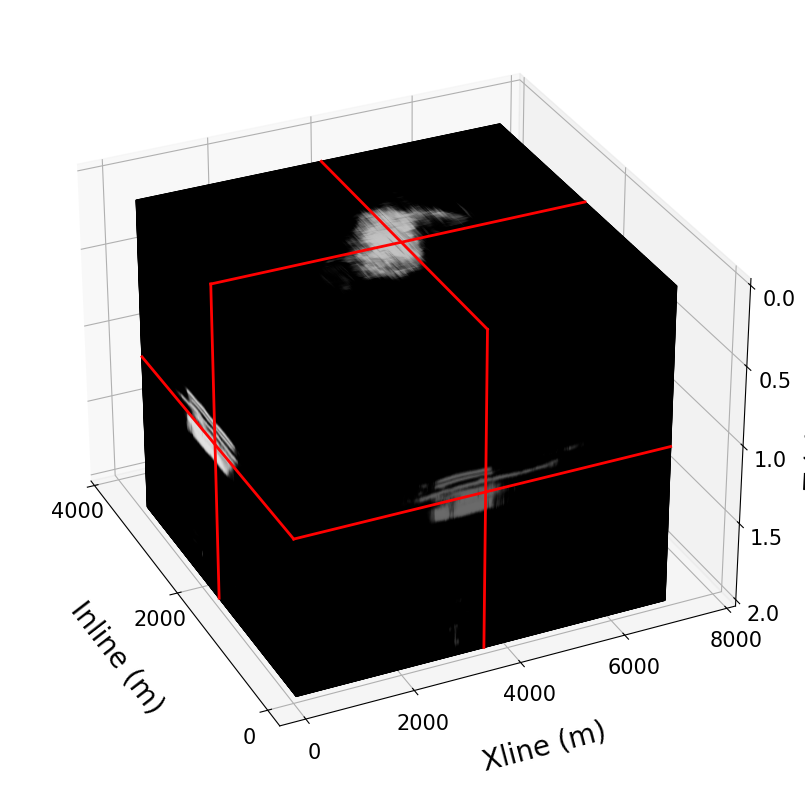

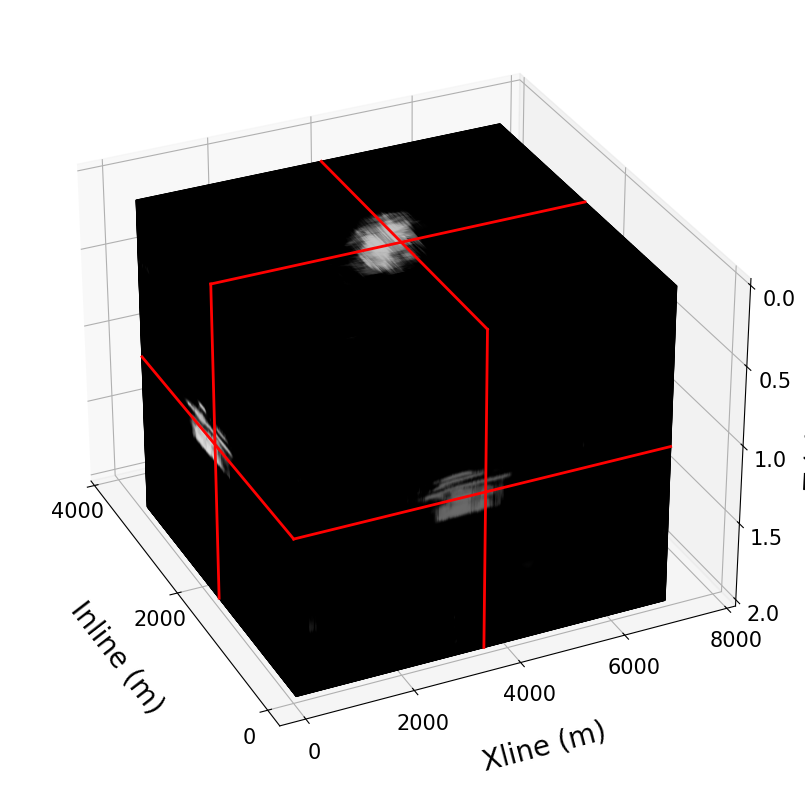

In [11]:
# two tests
year = ['2010_b01_t10','2004_b01_t07']
nyear = len(year)
Mask = []
for i in range(nyear):
    mask= np.fromfile(f'{test2D}/{year[i]}/test/tsMask.dat',dtype=np.float32)
    mask = np.reshape(mask,DD)
    Mask.append(mask)
    fig = show3D(mask,xyz=xyz,xyzi=(DD[0]//2,DD[1]//2,DD[2]//2),clim=[0,1])
    fig.savefig(f'{outpath}/figD2-2_mask_pred_{year[i]}.png',dpi=300)

### plot 2D layer results

In [12]:
path = f'../resources/label'
N = 9 # number of CO2 layers
lyidx = [0]
nfn = nyear

In [13]:
# load the T_top and T_base
T_top = np.fromfile(f'{path}/T_top.dat',dtype=np.float64)
T_base = np.fromfile(f'{path}/T_base.dat',dtype=np.float64)
T_top = np.reshape(T_top,(N,DD[0],DD[1]))
T_base = np.reshape(T_base,(N,DD[0],DD[1]))

In [14]:
# derive certain layer of predictions
lmp = np.zeros((nfn,len(lyidx),DD[0],DD[1]),dtype=np.float32)
for i,j in product(range(DD[0]),range(DD[1])):
    for c,k in enumerate(lyidx):
        Ttk = T_top[N-k-1,i,j]
        Tbk = T_base[N-k-1,i,j]
        mk = (td>=Ttk) * (td<=Tbk)
        if np.sum(mk) == 0:
            continue
        for n in range(nfn):
            lmp[n,c,i,j] = np.mean(Mask[n][i,j,mk])    

In [15]:
xa = xd[:,0]-np.amin(xd[:,0])
ya = yd[0,:]-np.amin(yd[0,:])

plot the pred CO2 plume from test dataset 2010_b01_t10:
plot the pred CO2 plume from test dataset 2004_b01_t07:


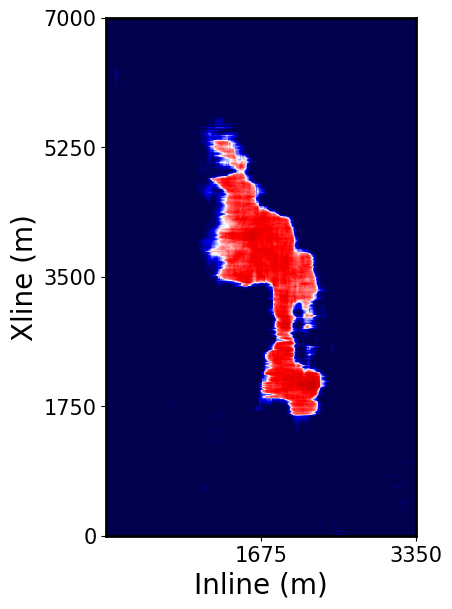

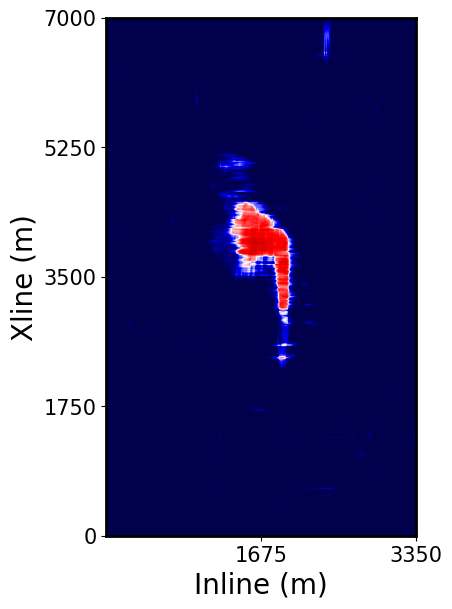

In [16]:
for i in range(nfn):   
    for j in range(len(lyidx)):                                                             
        print(f'plot the pred CO2 plume from test dataset {year[i]}:')
        fig,ax = plt.subplots(1,1,figsize=(4,8))
        ax.imshow(lmp[i,j].T,aspect=0.8,cmap='seismic',vmin=0,vmax=1,
                  extent=(xa[0],xa[-1],ya[0],ya[-1]))
        ax.set_ylabel('Xline (m)', fontsize=20)
        ax.set_xlabel('Inline (m)', fontsize=20)
        ytick = np.linspace(0,7000,5,dtype=np.int16) 
        xtick = np.linspace(0,xa[-1],3,dtype=np.int16)
        ax.set_xticks(xtick[1:])
        ax.set_xticklabels([f'{k}' for k in xtick[1:]],fontsize=15)
        ax.set_yticks(ytick)
        ax.set_yticklabels([f'{k}' for k in ytick],fontsize=15)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        BB = ax.get_position()
        BB.y0 = 0
        BB.x0 = -0.5
        BB.y1 = 8
        BB.x1 = 4
        fig.savefig(f'{outpath}/figD2-3_mask_pred_{year[i]}_{lyidx[j]}.png',dpi=300,bbox_inches=BB)